In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageFilter
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import image
from keras.applications import ResNet50

In [2]:

# Adjust the path to match your dataset
data_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images'

# Explore the directory structure
for dirname, _, filenames in os.walk(data_dir):
    print(f"Directory: {dirname}")
    for filename in filenames:
        print(f" - {filename}")


Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Tomato___Late_blight
 - 766771e1-8e8e-4ce4-9af6-b4ed91c9e80a___RS_Late.B 6881.JPG
 - 014d4972-1301-46d3-afc4-56470b774137___GHLB2 Leaf 8831.JPG
 - f8024ad7-ded1-42aa-ab6d-139f7069d10e___RS_Late.B 7157.JPG
 - f5261645-e84e-433a-8edb-ff53e8586646___GHLB2 Leaf 143.1.JPG
 - 017a9839-6097-45aa-85b0-3051db151484___RS_Late.B 5125.JPG
 - 2ac8376a-3401-4572-af45-6984e6415996___GHLB2 Leaf 8787.JPG
 - e1d00dcb-f2cb-41ca-8a45-a46c43e7c90e___GHLB2 Leaf 8697.JPG
 - 16c1763a-8e49-436c-865e-be56d8dadf4f___GHLB2 Leaf 9107.JPG
 - ca6362b2-b680-4348-a795-3bc37275e70f___GHLB2 Leaf 79.JPG
 - 0e244a32-08cd-471c-90dd-141c354c20b3___GHLB2 Leaf 8634.JPG
 - 8daa8725-05a2-4802-a524-9eba96fa89bc___RS_Late.B 6488.JPG
 - 2d583f2c-3e59-4c4c-be45-5f367a38af95___GHLB2 Leaf 8724.JPG
 - 63385691-5de8-4652-abe5-15727fdcab4b___RS_Late.B 5342.JPG
 - 06b911

In [3]:
# Adjust the path to match your dataset
data_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train'

# Explore the directory structure
for dirname, _, filenames in os.walk(data_dir):
    print(f"Directory: {dirname}")


Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Tomato___Late_blight
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Tomato___healthy
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Grape___healthy
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Potato___healthy
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Corn_(maize)___Northern_Leaf_Blight
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Tomato___Early_blight
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Tomato___Septoria_leaf_spot
Directory: /kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
image_size = (224, 224)

train_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images'
val_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'
batch_size = 64

# Function to load data
def load_data(data_dir):
    """Load images and labels from the directory."""
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load data
train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(val_dir)

# Normalize images to [0, 1]
train_images = train_images / 255.0
val_images = val_images / 255.0

# Split training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_encoded),
    y=train_labels_encoded
)
class_weights = dict(enumerate(class_weights))

# One-hot encode labels
num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes=num_classes)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

# Data generators
train_generator = train_datagen.flow(
    train_images, train_labels_one_hot, batch_size=batch_size
)
validation_generator = val_datagen.flow(
    val_images, val_labels_one_hot, batch_size=batch_size
)

# Debug information
print(f"Training set: {len(train_images)} samples")
print(f"Validation set: {len(val_images)} samples")
print(f"Number of classes: {num_classes}")
print(f"Class weights: {class_weights}")

# Save validation dataset images (optional)
def save_validation_images(images, labels, save_to_dir):
    os.makedirs(save_to_dir, exist_ok=True)
    for idx, (image, label) in enumerate(zip(images, labels)):
        label_dir = os.path.join(save_to_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        img = Image.fromarray((image * 255).astype(np.uint8))
        img_path = os.path.join(label_dir, f'{label}_{idx}.jpeg')
        img.save(img_path)

save_validation_images(val_images, val_labels_encoded, '/kaggle/working/validation_dataset')

# Debug directory structure
def debug_directory_structure(data_dir):
    for dirname, _, filenames in os.walk(data_dir):
        print(f"Directory: {dirname}, Files: {len(filenames)}")

debug_directory_structure('/kaggle/working/validation_dataset')


Training set: 1056 samples
Validation set: 264 samples
Number of classes: 9
Class weights: {0: 0.9386666666666666, 1: 1.8333333333333333, 2: 1.002849002849003, 3: 0.8691358024691358, 4: 1.7777777777777777, 5: 1.8333333333333333, 6: 1.1733333333333333, 7: 1.9234972677595628, 8: 0.36213991769547327}
Directory: /kaggle/working/validation_dataset, Files: 0
Directory: /kaggle/working/validation_dataset/6, Files: 20
Directory: /kaggle/working/validation_dataset/1, Files: 16
Directory: /kaggle/working/validation_dataset/4, Files: 14
Directory: /kaggle/working/validation_dataset/8, Files: 76
Directory: /kaggle/working/validation_dataset/5, Files: 16
Directory: /kaggle/working/validation_dataset/7, Files: 19
Directory: /kaggle/working/validation_dataset/2, Files: 43
Directory: /kaggle/working/validation_dataset/3, Files: 25
Directory: /kaggle/working/validation_dataset/0, Files: 35


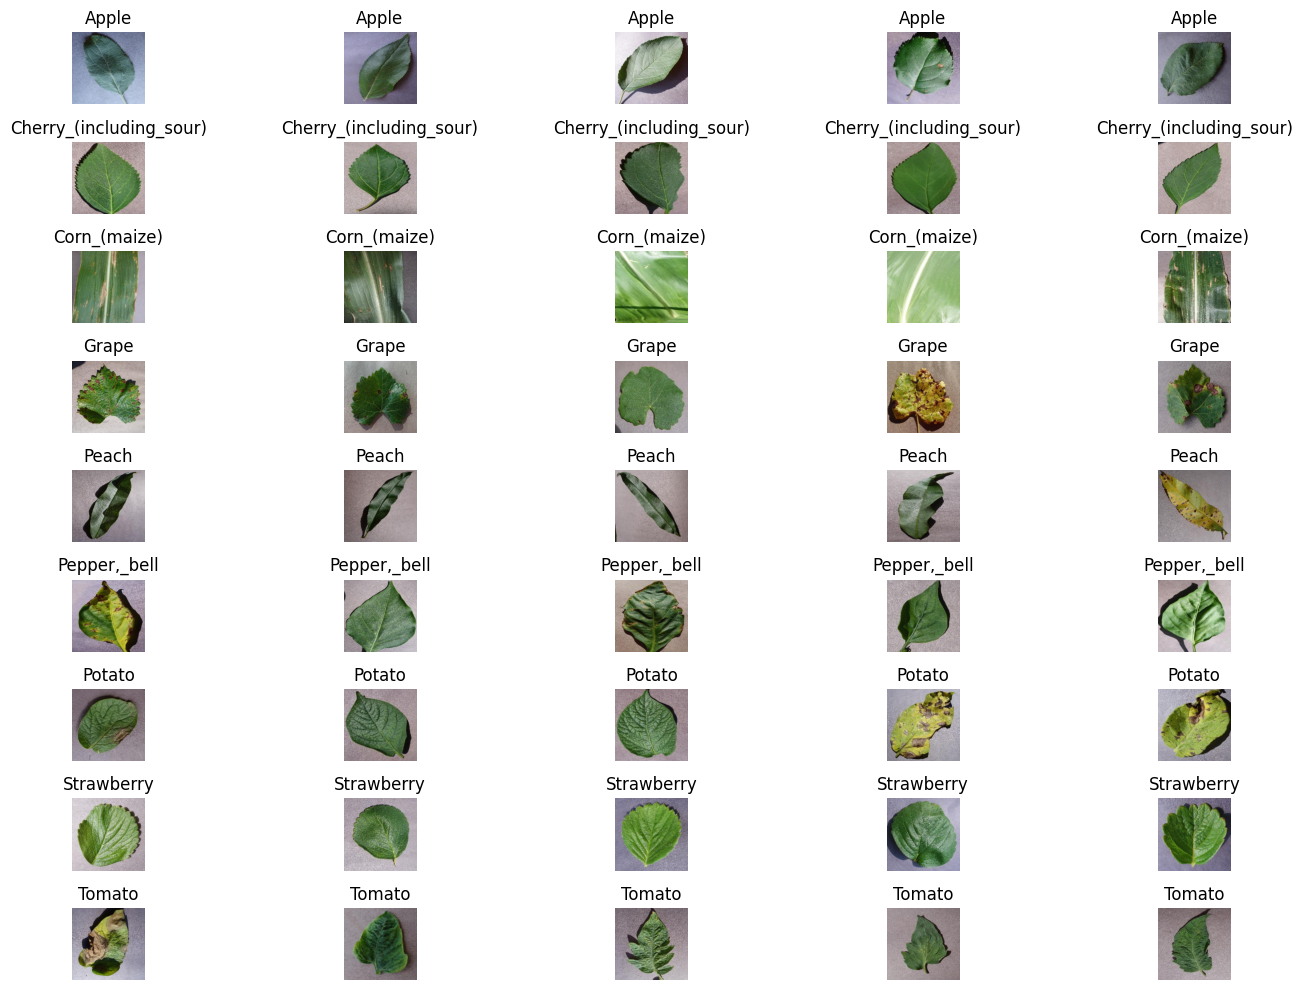

In [18]:
import matplotlib.pyplot as plt
import random

def visualize_samples(images, labels, label_encoder, num_samples=5):
    """Visualize a few sample images from each class."""
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        selected_indices = random.sample(list(label_indices), min(num_samples, len(label_indices)))
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx])
            plt.title(label_encoder.inverse_transform([label])[0])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_images, train_labels_encoded, label_encoder)


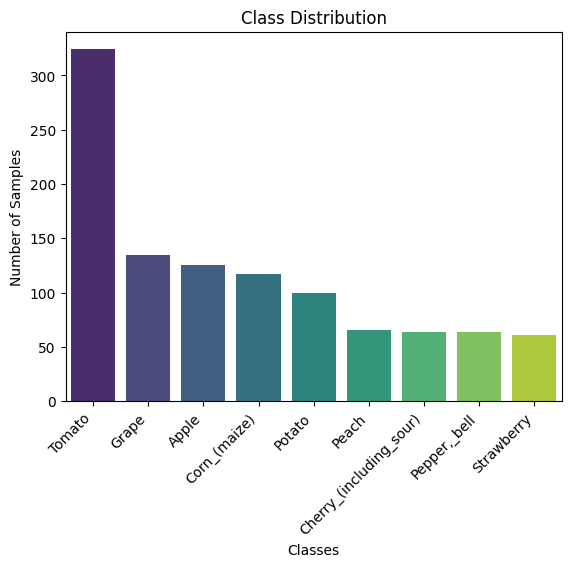

In [19]:
import seaborn as sns
import pandas as pd

def plot_class_distribution(labels, label_encoder):
    """Plot the distribution of classes."""
    label_counts = pd.Series(labels).value_counts()
    label_names = label_encoder.inverse_transform(label_counts.index)
    sns.barplot(x=label_names, y=label_counts.values, palette="viridis")
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_class_distribution(train_labels_encoded, label_encoder)


In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
# Define test directory (update path as needed)
test_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'

# Function to load test data
def load_test_data(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load test data
test_images, test_labels = load_test_data(test_dir)

# Normalize test images to [0, 1]
test_images = test_images / 255.0

# Encode test labels
test_labels_encoded = label_encoder.transform(test_labels)

# One-hot encode test labels
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

# Create test generator
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_images, test_labels_one_hot, batch_size=batch_size, shuffle=False
)

# Load MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    class_weight=class_weights
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734106007.971676     221 service.cc:145] XLA service 0x7ead1c003d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734106007.971730     221 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3:19 12s/step - accuracy: 0.1094 - loss: 2.9753

I0000 00:00:1734106012.740984     221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 725ms/step - accuracy: 0.3535 - loss: 2.1727 - val_accuracy: 0.8220 - val_loss: 0.4897
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step - accuracy: 0.8342 - loss: 0.4719 - val_accuracy: 0.9432 - val_loss: 0.1882
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 388ms/step - accuracy: 0.9062 - loss: 0.3190 - val_accuracy: 0.9470 - val_loss: 0.1447
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.9230 - loss: 0.1753 - val_accuracy: 0.9773 - val_loss: 0.0859
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.9289 - loss: 0.1792 - val_accuracy: 0.9697 - val_loss: 0.0914
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.9547 - loss: 0.1160 - val_accuracy: 0.9621 - val_loss: 0.1203
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.9714 - loss: 0.0966 - val_accuracy: 0.9621 - val_loss: 0.0900
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accuracy: 0.9590 - loss: 0.0995 - val_accuracy: 0.965

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Classification Report of MobileNET:
                         precision    recall  f1-score   support

                  Apple       0.93      0.97      0.95        40
Cherry_(including_sour)       0.87      1.00      0.93        20
           Corn_(maize)       1.00      1.00      1.00        40
                  Grape       1.00      0.97      0.99        40
                  Peach       1.00      0.90      0.95        20
           Pepper,_bell       1.00      1.00      1.00        20
                 Potato       1.00      0.97      0.98        30
             Strawberry       1.00      1.00      1.00        20
                 Tomato       0.98      0.97      0.97       100

               accuracy                           0.98       330
              macro avg       0.98      0.98      0.97       330
           weighted avg       0.98      0.98      0.98       330



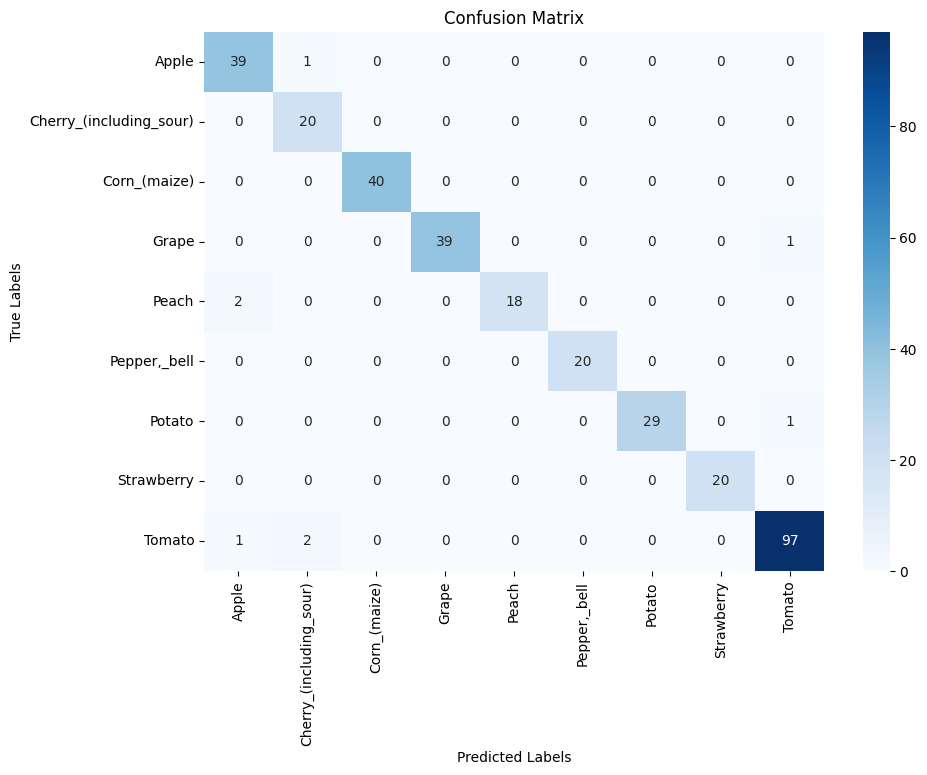

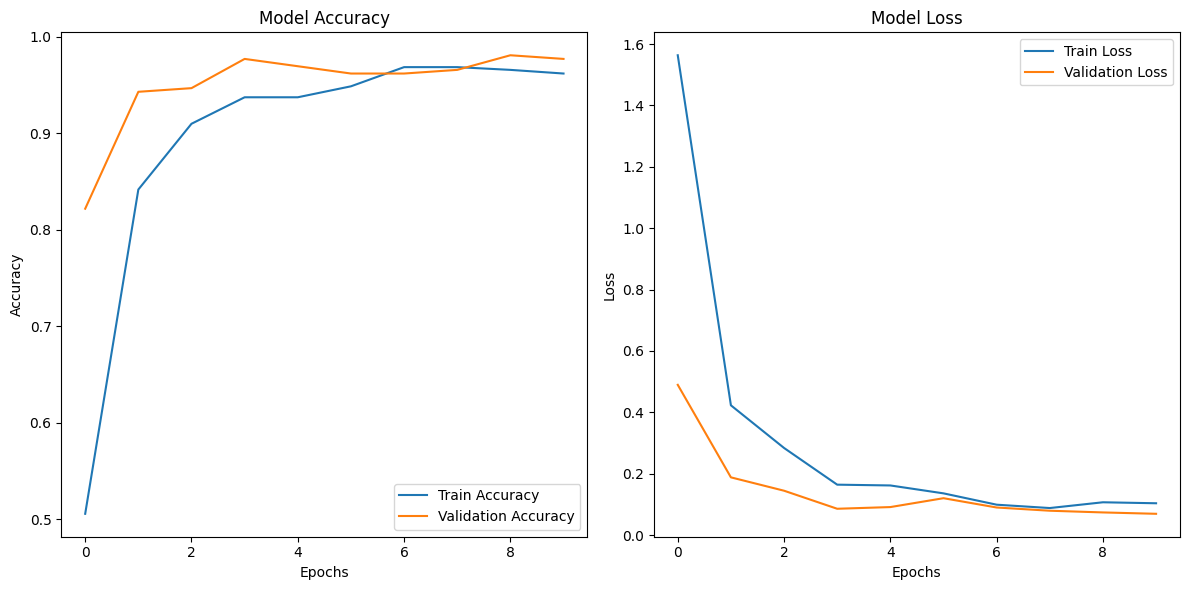

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image


# Predict on the test data
predictions = model.predict(test_generator)

# Get the predicted labels (using argmax for classification)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (from the test generator)
true_labels = test_labels_encoded

# Classification Report with Plant Names
print("Classification Report of MobileNET:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Visualization (if you saved the history of training)
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
import os

model_dir = os.path.join(os.getcwd(), 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)  # Create the directory if it doesn't exist

model_save_path = os.path.join(model_dir, 'mobilenet_model.h5')


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os

# Define test directory (update path as needed)
test_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'

# Function to load test data
def load_test_data(data_dir, image_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load test data
test_images, test_labels = load_test_data(test_dir)

# Normalize test images to [0, 1]
test_images = test_images / 255.0

# Encode test labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# One-hot encode test labels
num_classes = len(label_encoder.classes_)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

# Create test generator
batch_size = 32
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_images, test_labels_one_hot, batch_size=batch_size, shuffle=False
)

# Define AlexNet model
model = Sequential()

# Convolutional layers and max pooling layers (AlexNet architecture)
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model (Note: You need to define 'train_generator' and 'validation_generator' for training)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    class_weight=class_weights
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2024-12-13 16:18:38.161796: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,96,26,26]{3,2,1,0}, f32[64,256,26,26]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-13 16:18:38.174615: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.013015759s
Trying algorithm eng0{} for conv (f32[256,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,96,26,26]{3,2,1,0}, f32[64,256,26,26]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_ba

17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 806ms/step - accuracy: 0.0992 - loss: 10.5962 - val_accuracy: 0.0606 - val_loss: 2.1887
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.0825 - loss: 2.2471 - val_accuracy: 0.0606 - val_loss: 2.1962
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.0765 - loss: 2.2183 - val_accuracy: 0.0720 - val_loss: 2.1954
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.0994 - loss: 2.1987 - val_accuracy: 0.1288 - val_loss: 2.1931
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.0773 - loss: 2.2625 - val_accuracy: 0.0720 - val_loss: 2.1974
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.0746 - loss: 2.2274 - val_accuracy: 0.0606 - val_loss: 2.1995
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.0728 - loss: 2.1678 - val_accuracy: 0.1629 - val_loss: 2.1891
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - accuracy: 0.1249 - loss: 2.2126 - val_accuracy: 0.16

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.1131 - loss: 2.1885
Test Accuracy: 0.12


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Classification Report:
                         precision    recall  f1-score   support

                  Apple       0.00      0.00      0.00        40
Cherry_(including_sour)       0.00      0.00      0.00        20
           Corn_(maize)       0.12      1.00      0.22        40
                  Grape       0.00      0.00      0.00        40
                  Peach       0.00      0.00      0.00        20
           Pepper,_bell       0.00      0.00      0.00        20
                 Potato       0.00      0.00      0.00        30
             Strawberry       0.00      0.00      0.00        20
                 Tomato       0.00      0.00      0.00       100

               accuracy                           0.12       330
              macro avg       0.01      0.11      0.02       330
           weighted avg       0.01      0.12      0.03       330



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


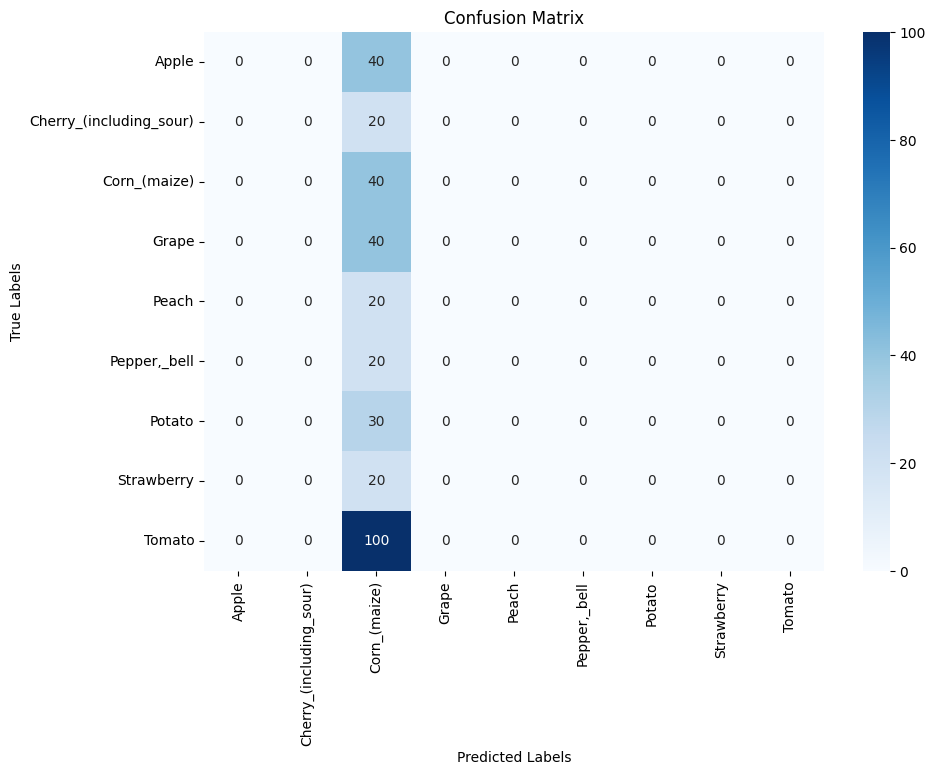

In [13]:
# Predict on the test data
predictions = model.predict(test_generator)

# Get the predicted labels (using argmax for classification)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (from the test generator)
true_labels = test_labels_encoded

# Classification Report with Plant Names
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os

# Define test directory (update path as needed)
test_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'

# Function to load test data
def load_test_data(data_dir, image_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load test data
test_images, test_labels = load_test_data(test_dir)

# Normalize test images to [0, 1]
test_images = test_images / 255.0

# Encode test labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# One-hot encode test labels
num_classes = len(label_encoder.classes_)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

# Create test generator
batch_size = 32
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_images, test_labels_one_hot, batch_size=batch_size, shuffle=False
)

# Define VGG16 model with pre-trained weights (without top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the new model with custom layers on top of VGG16
model = Sequential()
model.add(base_model)  # Add the VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dense(4096, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(4096, activation='relu'))  # Another fully connected layer
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model (Note: You need to define 'train_generator' and 'validation_generator' for training)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    class_weight=class_weights
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.1484 - loss: 21.5240 - val_accuracy: 0.1780 - val_loss: 2.2808
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - accuracy: 0.1903 - loss: 2.1055 - val_accuracy: 0.5265 - val_loss: 1.3861
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 437ms/step - accuracy: 0.4355 - loss: 1.4136 - val_accuracy: 0.6742 - val_loss: 0.9483
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.5332 - loss: 1.1272 - val_accuracy: 0.7386 - val_loss: 0.7100
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - accuracy: 0.5721 - loss: 1.0605 - val_accuracy: 0.7689 - val_loss: 0.6430
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.5967 - loss: 0.9790 - val_accuracy: 0.8106 - val_loss: 0.5456
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.6296 - loss: 0.9275 - val_accuracy: 0.8068 - val_loss: 0.5370
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 419ms/

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.8910 - loss: 0.2913
Test Accuracy: 0.90


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Classification Report:
                         precision    recall  f1-score   support

                  Apple       0.93      0.68      0.78        40
Cherry_(including_sour)       0.70      0.95      0.81        20
           Corn_(maize)       1.00      0.90      0.95        40
                  Grape       0.97      0.95      0.96        40
                  Peach       0.70      0.95      0.81        20
           Pepper,_bell       1.00      0.95      0.97        20
                 Potato       0.85      0.97      0.91        30
             Strawberry       0.77      1.00      0.87        20
                 Tomato       0.98      0.91      0.94       100

               accuracy                           0.90       330
              macro avg       0.88      0.92      0.89       330
           weighted avg       0.92      0.90      0.90       330



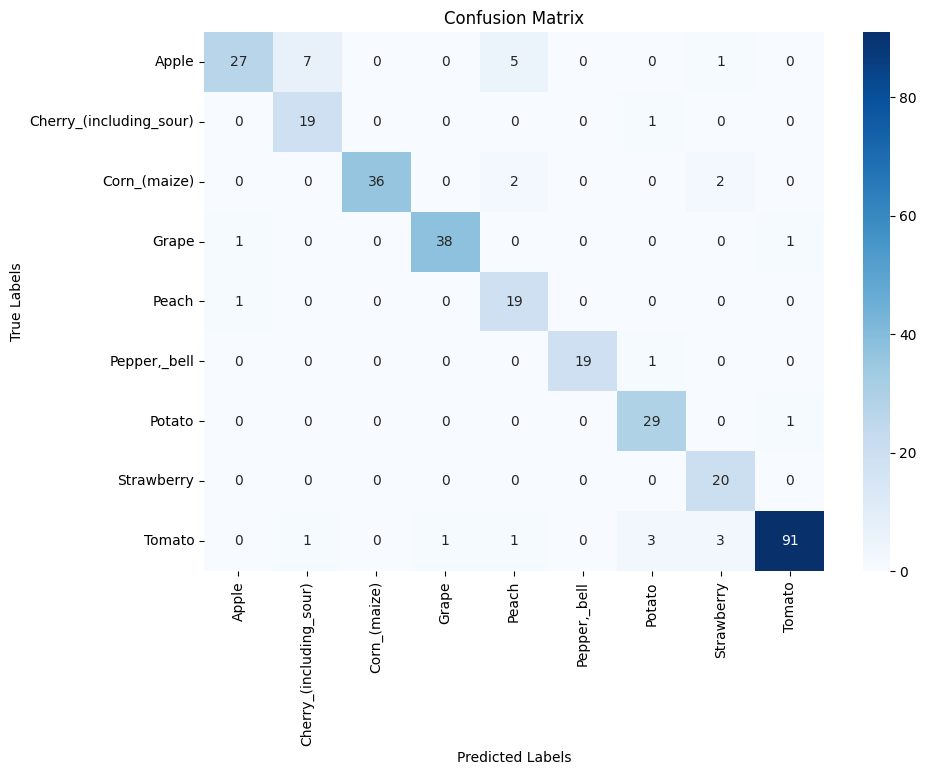

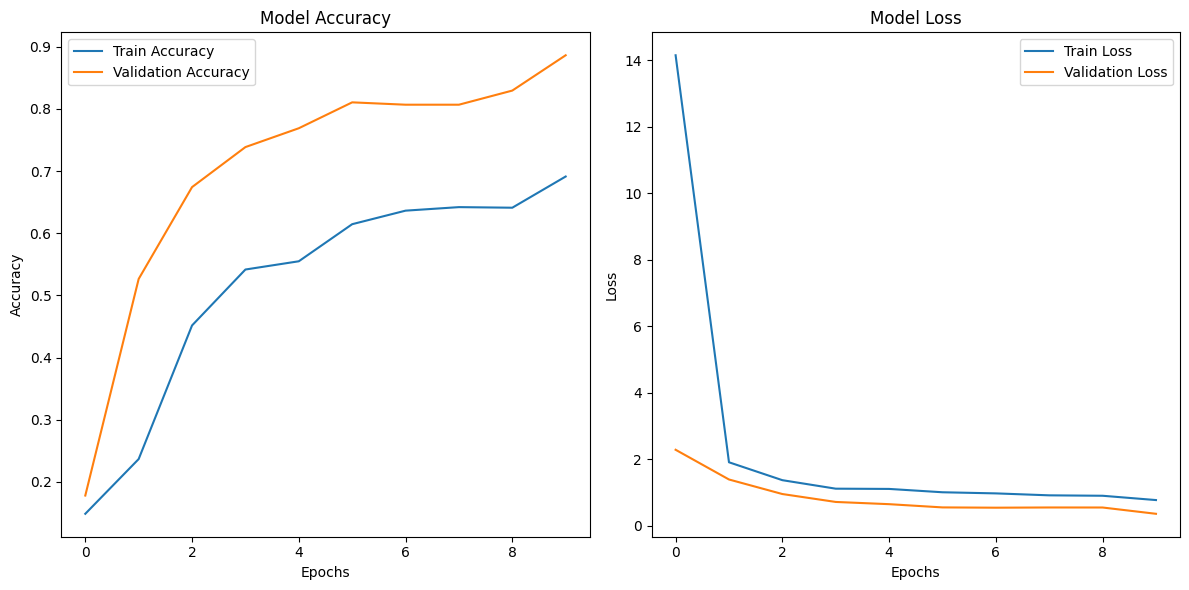

In [15]:
# Predict on the test data
predictions = model.predict(test_generator)

# Get the predicted labels (using argmax for classification)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (from the test generator)
true_labels = test_labels_encoded

# Classification Report with Plant Names
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Visualization (if you saved the history of training)
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()